In [1]:
import tensorflow as tf
import pathlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras import activations
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation, Add

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
country_images_root = pathlib.Path("/home/pascal_steiger/Downloads/data/")

In [4]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr

In [5]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

img_df.sample(n=10)

,path,label
18,/home/pascal_steiger/Downloads/data/MKD/img_MK...,MKD
12107,/home/pascal_steiger/Downloads/data/FIN/img_FI...,FIN
26025,/home/pascal_steiger/Downloads/data/SWE/img_SW...,SWE
2116,/home/pascal_steiger/Downloads/data/ISL/img_IS...,ISL
8341,/home/pascal_steiger/Downloads/data/FRA/img_44...,FRA
25422,/home/pascal_steiger/Downloads/data/DNK/img_DN...,DNK
8727,/home/pascal_steiger/Downloads/data/FRA/img_49...,FRA
14521,/home/pascal_steiger/Downloads/data/ESP/img_ES...,ESP
1578,/home/pascal_steiger/Downloads/data/HRV/img_HR...,HRV
1161,/home/pascal_steiger/Downloads/data/HRV/img_HR...,HRV


In [6]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)

                                                    path label
14424  /home/pascal_steiger/Downloads/data/ESP/img_ES...   ESP
8524   /home/pascal_steiger/Downloads/data/FRA/img_44...   FRA
2693   /home/pascal_steiger/Downloads/data/ISL/img_IS...   ISL
26125  /home/pascal_steiger/Downloads/data/SWE/img_SW...   SWE
16763  /home/pascal_steiger/Downloads/data/PRT/img_PR...   PRT
(21234, 2)
                                                    path label
15837  /home/pascal_steiger/Downloads/data/BGR/img_BG...   BGR
9272   /home/pascal_steiger/Downloads/data/LTU/img_LT...   LTU
4903   /home/pascal_steiger/Downloads/data/ITA/img_IT...   ITA
22646  /home/pascal_steiger/Downloads/data/NLD/img_52...   NLD
10217  /home/pascal_steiger/Downloads/data/AUT/img_AU...   AUT
(5309, 2)


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(400, 400),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(400, 400),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 21234 validated image filenames belonging to 26 classes.
Found 5309 validated image filenames belonging to 26 classes.


In [9]:
with tf.device("/device:GPU:0"):   
    I = Input(shape=(400,400,3), dtype="float32")

    c2d1= Conv2D(32, (3, 3), (2, 2), activation="relu")(I)
    b1 = BatchNormalization()(c2d1)
    c2d2= Conv2D(64, (3, 3), activation="relu")(b1)
    b2 = BatchNormalization()(c2d2)

    c1d1= Conv2D(1, 1, (2, 2))(b2)
    b3 = BatchNormalization()(c1d1)

    sc2d1= SeparableConv2D(128, (3, 3), padding="same")(b2)
    b4 = BatchNormalization()(sc2d1)
    relu1= Activation(activations.relu)(b4)
    sc2d2= SeparableConv2D(128, (3, 3), padding="same")(relu1)
    b5 = BatchNormalization()(sc2d2)
    mp1= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b5)

    add1 = Add()([b3, mp1])

    c1d2= Conv2D(1, 1, (2, 2))(add1)
    b6 = BatchNormalization()(c1d2)

    relu2= Activation(activations.relu)(add1)
    sc2d3= SeparableConv2D(256, (3, 3), padding="same")(relu2)
    b7 = BatchNormalization()(sc2d3)
    relu3= Activation(activations.relu)(b7)
    sc2d4= SeparableConv2D(256, (3, 3), padding="same")(relu3)
    b8 = BatchNormalization()(sc2d4)
    mp2= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b8)

    add2 = Add()([b6, mp2])

    c1d3= Conv2D(1, 1, (2, 2))(add2)
    b9 = BatchNormalization()(c1d3)

    relu4= Activation(activations.relu)(add2)
    sc2d5= SeparableConv2D(728, (3, 3), padding="same")(relu4)
    b10 = BatchNormalization()(sc2d5)
    relu5= Activation(activations.relu)(b10)
    sc2d6= SeparableConv2D(728, (3, 3), padding="same")(relu5)
    b11 = BatchNormalization()(sc2d6)
    mp3= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b11)

    add3 = Add()([b9, mp3])

    relu6= Activation(activations.relu)(add3)
    sc2d7= SeparableConv2D(728, (3, 3), padding="same")(relu6)
    b12 = BatchNormalization()(sc2d7)
    relu7= Activation(activations.relu)(b12)
    sc2d8= SeparableConv2D(728, (3, 3), padding="same")(relu7)
    b13 = BatchNormalization()(sc2d8)

    add4 = Add()([add3, b13])

    relu8= Activation(activations.relu)(add4)
    sc2d9= SeparableConv2D(728, (3, 3), padding="same")(relu8)
    b14 = BatchNormalization()(sc2d9)
    relu9= Activation(activations.relu)(b14)
    sc2d10= SeparableConv2D(728, (3, 3), padding="same")(relu9)
    b15 = BatchNormalization()(sc2d10)

    add5 = Add()([add4, b15])

    relu10= Activation(activations.relu)(add5)
    sc2d11= SeparableConv2D(728, (3, 3), padding="same")(relu10)
    b16 = BatchNormalization()(sc2d11)
    relu11= Activation(activations.relu)(b16)
    sc2d12= SeparableConv2D(728, (3, 3), padding="same")(relu11)
    b17 = BatchNormalization()(sc2d12)

    add6 = Add()([add5, b17])

    relu12= Activation(activations.relu)(add6)
    sc2d13= SeparableConv2D(728, (3, 3), padding="same")(relu12)
    b18 = BatchNormalization()(sc2d13)
    relu13= Activation(activations.relu)(b18)
    sc2d14= SeparableConv2D(728, (3, 3), padding="same")(relu13)
    b19 = BatchNormalization()(sc2d14)

    add7 = Add()([add6, b19])

    relu14= Activation(activations.relu)(add7)
    sc2d15= SeparableConv2D(728, (3, 3), padding="same")(relu14)
    b20 = BatchNormalization()(sc2d15)
    relu15= Activation(activations.relu)(b20)
    sc2d16= SeparableConv2D(728, (3, 3), padding="same")(relu15)
    b21 = BatchNormalization()(sc2d16)

    add8 = Add()([add7, b21])

    c1d4= Conv2D(1, 1, (2, 2))(add8)
    b21 = BatchNormalization()(c1d4)

    relu16= Activation(activations.relu)(add8)
    sc2d17= SeparableConv2D(728, (3, 3), padding="same")(relu16)
    b22 = BatchNormalization()(sc2d17)
    relu17= Activation(activations.relu)(b22)
    sc2d18= SeparableConv2D(1024, (3, 3), padding="same")(relu17)
    b23 = BatchNormalization()(sc2d18)
    mp9= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b23)

    add9 = Add()([b21, mp9])

    sc2d19= SeparableConv2D(1536, (3, 3), activation="relu")(add9)
    b24 = BatchNormalization()(sc2d19)
    sc2d20= SeparableConv2D(2048, (3, 3), activation="relu")(b24)
    b25 = BatchNormalization()(sc2d20)

    gap = GlobalAveragePooling2D()(b25)

    flat = Flatten()(gap)
    dense = Dense(1024, activation='relu')(flat)
    dropout = Dropout(0.1)(dense)
    dense2 = Dense(512, activation='relu')(dropout)
    dropout2 = Dropout(0.1)(dense2)
    dense3 = Dense(26, activation='softmax')(dropout2)

    model = tf.keras.Model(I, dense3)
    
    for layer in model.layers[:]:
        layer.trainable = True 

In [10]:
early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [11]:
with tf.device("/device:GPU:0"):
    model.compile(optimizer = tf.optimizers.Nadam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [12]:
with tf.device("/device:GPU:0"):
    history = model.fit(train_generator,
      #steps_per_epoch=2000 // 32,  
      epochs=200,
      verbose=1,
      validation_data = validation_generator,
      callbacks = callbacks)

Epoch 1/200
664/664 [==============================] - 1083s 2s/step - loss: 3.0778 - sparse_categorical_accuracy: 0.1052 - val_loss: 3.3724 - val_sparse_categorical_accuracy: 0.0919
Epoch 2/200
664/664 [==============================] - 1060s 2s/step - loss: 2.8151 - sparse_categorical_accuracy: 0.1637 - val_loss: 4.7356 - val_sparse_categorical_accuracy: 0.0750
Epoch 3/200
664/664 [==============================] - 1061s 2s/step - loss: 2.6753 - sparse_categorical_accuracy: 0.2040 - val_loss: 2.9232 - val_sparse_categorical_accuracy: 0.1582
Epoch 4/200
664/664 [==============================] - 1062s 2s/step - loss: 2.5727 - sparse_categorical_accuracy: 0.2304 - val_loss: 3.3375 - val_sparse_categorical_accuracy: 0.1241
Epoch 5/200
664/664 [==============================] - 1063s 2s/step - loss: 2.4770 - sparse_categorical_accuracy: 0.2585 - val_loss: 2.9582 - val_sparse_categorical_accuracy: 0.1916
Epoch 6/200
664/664 [==============================] - 1059s 2s/step - loss: 2.3965 -

664/664 [==============================] - 1057s 2s/step - loss: 0.6776 - sparse_categorical_accuracy: 0.7783 - val_loss: 2.0240 - val_sparse_categorical_accuracy: 0.5027
Epoch 46/200
664/664 [==============================] - 1056s 2s/step - loss: 0.6578 - sparse_categorical_accuracy: 0.7839 - val_loss: 2.2936 - val_sparse_categorical_accuracy: 0.4863
Epoch 47/200
664/664 [==============================] - 1056s 2s/step - loss: 0.6383 - sparse_categorical_accuracy: 0.7937 - val_loss: 2.2037 - val_sparse_categorical_accuracy: 0.4871
Epoch 48/200
664/664 [==============================] - 1078s 2s/step - loss: 0.6097 - sparse_categorical_accuracy: 0.7974 - val_loss: 2.4723 - val_sparse_categorical_accuracy: 0.4566
Epoch 49/200
664/664 [==============================] - 1056s 2s/step - loss: 0.6052 - sparse_categorical_accuracy: 0.8044 - val_loss: 2.1531 - val_sparse_categorical_accuracy: 0.4879
Epoch 50/200
664/664 [==============================] - 1058s 2s/step - loss: 0.5743 - sparse

Epoch 89/200
664/664 [==============================] - 1056s 2s/step - loss: 0.0900 - sparse_categorical_accuracy: 0.9698 - val_loss: 2.8257 - val_sparse_categorical_accuracy: 0.5688
Epoch 90/200
664/664 [==============================] - 1057s 2s/step - loss: 0.0873 - sparse_categorical_accuracy: 0.9716 - val_loss: 2.7712 - val_sparse_categorical_accuracy: 0.5639
Epoch 91/200
664/664 [==============================] - 1057s 2s/step - loss: 0.0798 - sparse_categorical_accuracy: 0.9737 - val_loss: 2.9332 - val_sparse_categorical_accuracy: 0.5630
Epoch 92/200
664/664 [==============================] - 1056s 2s/step - loss: 0.0874 - sparse_categorical_accuracy: 0.9700 - val_loss: 2.8763 - val_sparse_categorical_accuracy: 0.5711

Epoch 00092: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 93/200
664/664 [==============================] - 1058s 2s/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9780 - val_loss: 2.8650 - val_sparse_categorical_accuracy: 0.5777

In [13]:
with tf.device("/device:GPU:0"):
    model.save('CNN_v5_fullNet.h5')

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


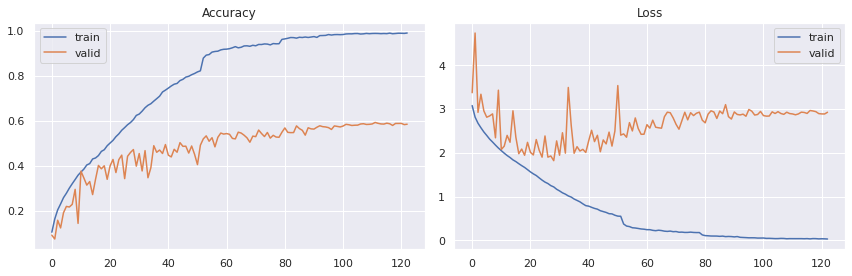

In [14]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(400,400)_v5.png')

plt.show()

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 199, 199, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 199, 199, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 197, 197, 64) 18496       batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=603
batch_size=32
Y_pred = model.predict(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = sorted(labelStringArr)
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 93   4   2   8   6   4   2   3   0   9   4   5   7   1   1   7   1   3
    1   1   4   7   2   8  11   1]
 [  7  62   1   3   7   5   3   1   0  12  21   1   3  15   1   4   1   0
    1  19   4   5   1   6   2   2]
 [  0   0 149   3   8   0   2   0   0   2   2   5   7   1   0   0   0   1
    9   0   0   1   5   5   5   0]
 [  3   1   4 162   1   1   3   0   1   3   1   2   0   1   0   0   1   0
    0   0   1   1   1   0   4   3]
 [  7   6   7   1  93  11   6   2   3   5   2   4   9   5   1   7   0   3
    2   8   2  13   0  10   8   2]
 [  1   7   0   0   3 106   3   3   0   3  10   2   4  13   0   4   3   3
    1  11   7   5   2   0   2   3]
 [  3   7   2   2   4   1 177   0   3  13   5  13   1   0   1   6   1   2
   11   2   2   3  29   4  12   3]
 [  0   2   1   2   2   1   2 148   0   1   2   1   2   0   1   0   5   5
    0   1   2   3   1   2   4   0]
 [  0   2   2   1   0   0   0   2 171   3   1   1   0   1   0   1   1   2
    0   2   7   0   0   1   2  16]
 [